<a href="https://colab.research.google.com/github/bigfoot-5/Applied-AI/blob/main/Dave_Talluri_Tucker_201666181_201667130_201674343.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing required libraries
!pip install segmentation-models-pytorch
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 13.4 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=1ca800fbfca6bebe927b4c6864b2c0e5fd4e568af4de80f5b1ef8726b5531bd7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=07ac5902c3c098a39bb7fea8a3694b5efd98cf8853064e86a37b2909ad6ac3f3
  Stored in directory: /root/.cache/pip/w

In [ ]:
# Libraries used to build Semantic Segmentation models
import torch
import time
import torchvision
import os, os.path
import random
import torchvision.transforms as transforms
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, ConcatDataset, Dataset
import torch.optim.lr_scheduler as lr_scheduler
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from torchvision.transforms.functional import to_tensor
from PIL import Image
import segmentation_models_pytorch as smp
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task = "multiclass", num_classes = 32)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Visualizing the Dataset

 Number of samples for original images of train set are 90
 Number of samples for masked images for the train set are 90
 Number of samples for original images of test set  are 11
 Number of samples for masked images of the test set are are 11
Displaying the first 6 images from train_image_paths:


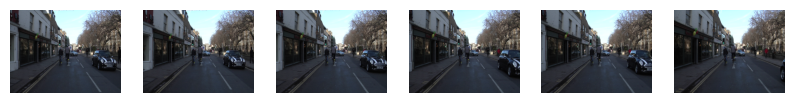

Displaying the first 6 images from train_mask_paths:


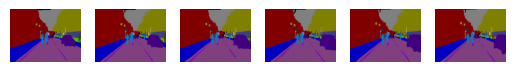

Displaying the first 6 images from test__image_paths:


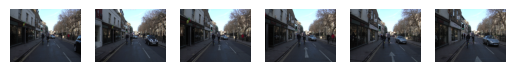

Displaying the first 6 images from test_mask_paths:


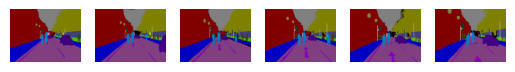

In [ ]:
# Splitting dataset to images and labels before visualization
train_path = '/content/drive/MyDrive/Applied AI/CA3/train'
test_path = '/content/drive/MyDrive/Applied AI/CA3/test'
train_image_paths = []
train_mask_paths = []
test__image_paths = []
test_mask_paths = []

for filename in os.listdir(train_path):
    if not filename.endswith('_L.png'):
        train_image_paths.append(os.path.join(train_path, filename))

for filename in os.listdir(train_path):
    if filename.endswith('_L.png'):
        train_mask_paths.append(os.path.join(train_path, filename))

for filename in os.listdir(test_path):
    if not filename.endswith('_L.png'):
        test__image_paths.append(os.path.join(test_path, filename))

for filename in os.listdir(test_path):
    if filename.endswith('_L.png'):
        test_mask_paths.append(os.path.join(test_path, filename))

print(f" Number of samples for original images of train set are {len(train_image_paths)}")
print(f" Number of samples for masked images for the train set are {len(train_mask_paths)}")
print(f" Number of samples for original images of test set  are {len(test__image_paths)}")
print(f" Number of samples for masked images of the test set are are {len(test_mask_paths)}")

figure = plt.figure(figsize=(10, 10))
cols, rows = 6, 6

# Display the first 6 images from image_paths
print("Displaying the first 6 images from train_image_paths:")
for i in range(6):
    image_path = train_image_paths[i]
    img = Image.open(image_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Display the first 6 images from train_mask_paths
print("Displaying the first 6 images from train_mask_paths:")
for i in range(6):
    mask_path = train_mask_paths[i]
    img = Image.open(mask_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Display the first 6 images from test__image_paths
print("Displaying the first 6 images from test__image_paths:")
for i in range(6):
    image_path_t = test__image_paths[i]
    img = Image.open(image_path_t)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Display the first 6 images from test_mask_paths
print("Displaying the first 6 images from test_mask_paths:")
for i in range(6):
    mask_path_t = test_mask_paths[i]
    img = Image.open(mask_path_t)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()


In [ ]:
class_color_codes = {
    'Animal': [64, 128, 64],
    'Archway': [192, 0, 128],
    'Bicyclist': [0, 128, 192],
    'Bridge': [0, 128, 64],
    'Building': [128, 0, 0],
    'Car': [64, 0, 128],
    'CartLuggagePram': [64, 0, 192],
    'Child': [192, 128, 64],
    'Column_Pole': [192, 192, 128],
    'Fence': [64, 64, 128],
    'LaneMkgsDriv': [128, 0, 192],
    'LaneMkgsNonDriv': [192, 0, 64],
    'Misc_Text': [128, 128, 64],
    'MotorcycleScooter': [192, 0, 192],
    'OtherMoving': [128, 64, 64],
    'ParkingBlock': [64, 192, 128],
    'Pedestrian': [64, 64, 0],
    'Road': [128, 64, 128],
    'RoadShoulder': [128, 128, 192],
    'Sidewalk': [0, 0, 192],
    'SignSymbol': [192, 128, 128],
    'Sky': [128, 128, 128],
    'SUVPickupTruck': [64, 128, 192],
    'TrafficCone': [0, 0, 64],
    'TrafficLight': [0, 64, 64],
    'Train': [192, 64, 128],
    'Tree': [128, 128, 0],
    'Truck_Bus': [192, 128, 192],
    'Tunnel': [64, 0, 64],
    'VegetationMisc': [192, 192, 0],
    'Void': [0, 0, 0],
    'Wall': [64, 192, 0]
}
class_colors = {
    0: [64, 128, 64],
    1: [192, 0, 128],
    2: [0, 128, 192],
    3: [0, 128, 64],
    4: [128, 0, 0],
    5: [64, 0, 128],
    6: [64, 0, 192],
    7: [192, 128, 64],
    8: [192, 192, 128],
    9: [64, 64, 128],
    10: [128, 0, 192],
    11: [192, 0, 64],
    12: [128, 128, 64],
    13: [192, 0, 192],
    14: [128, 64, 64],
    15: [64, 192, 128],
    16: [64, 64, 0],
    17: [128, 64, 128],
    18: [128, 128, 192],
    19: [0, 0, 192],
    20: [192, 128, 128],
    21: [128, 128, 128],
    22: [64, 128, 192],
    23: [0, 0, 64],
    24: [0, 64, 64],
    25: [192, 64, 128],
    26: [128, 128, 0],
     27: [192, 128, 192],
    28: [64, 0, 64],
    29: [192, 192, 0],
    30: [0, 0, 0],
    31: [64, 192, 0]
}


In [ ]:
# Defining size of each image in dataset
height = 720
width = 960

# Function to tranform images to tensor
def transform(image, mask):
    image = transforms.ToTensor()(image)
    mask = mask
    return image, mask

# Class to perform tranformations and conversion to one hot encoding on images
class CustomDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")
        mask = np.array(mask)

        # Create an empty tensor for one-hot encoding
        num_classes = len(class_color_codes)
        one_hot_masks = torch.zeros((num_classes, height, width))

        for i, class_name in enumerate(class_color_codes):
            # Get the RGB color code for the current class
            color_code = class_color_codes[class_name]
            # Create a boolean mask for pixels with the current color code
            mask_i = np.all(mask == color_code, axis=2)
            # Convert the boolean mask to a binary tensor
            mask_i = torch.as_tensor(mask_i, dtype=torch.uint8)
            # Assign the binary tensor to the corresponding channel of the one-hot tensor
            one_hot_masks[i, :, :] = mask_i

        if self.transform is not None:
            image, one_hot_masks = self.transform(image,one_hot_masks)
        return image, one_hot_masks

# Class to expand training dataset by using data augmentation techniques for each training image
class AugmentedDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("RGB")
        image = np.array(image)
        mask = np.array(mask)

        # Create an empty tensor for one-hot encoding
        num_classes = len(class_color_codes)
        one_hot_masks = torch.zeros((num_classes, height, width))

        for i, class_name in enumerate(class_color_codes):
            # Get the RGB color code for the current class
            color_code = class_color_codes[class_name]
            # Create a boolean mask for pixels with the current color code
            mask_i = np.all(mask == color_code, axis=2)
            # Convert the boolean mask to a binary tensor
            mask_i = torch.as_tensor(mask_i, dtype=torch.uint8)
            # Assign the binary tensor to the corresponding channel of the one-hot tensor
            one_hot_masks[i, :, :] = mask_i

        if self.transform is not None:
            augmented = self.transform(image=image, mask=one_hot_masks.numpy())
            image = augmented['image']
            mask = augmented['mask']

        # Convert image and mask to tensors
        image = transforms.ToTensor()(image)
        mask = torch.from_numpy(mask)
        return image, mask

# Define the path to your dataset and create a list of image and mask paths
# Define the transforms to be applied to the images
# Create an instance of the CustomDataset class
training_dataset = CustomDataset(train_image_paths, train_mask_paths, transform)
testing_dataset = CustomDataset(test__image_paths, test_mask_paths, transform)
augmented_datasets = []

for i in range(1):
    augmented_transform = A.Compose([
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue = 0.2)
    ])
    augmented_dataset = AugmentedDataset(train_image_paths, train_mask_paths, augmented_transform)
    augmented_datasets.append(augmented_dataset)

expanded_dataset = ConcatDataset([training_dataset] + augmented_datasets)
print(f"the number of samples in the augumented training dataset is {len(expanded_dataset)}")

# Create a DataLoader instance to load the data in batches
batch_size = 10
dataloader = DataLoader(expanded_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

the number of samples in the augumented training dataset is 180


**PSPNet** Baseline Model

In [ ]:
# Using pretrained PSPNet Model with backbone resnet101
model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100

            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 74.7MB/s]


FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


KeyboardInterrupt: ignored

Loss Function Exploration

Dice Loss

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)
for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []

            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100

            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Optimizer Exploration

SGD

In [ ]:
model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

ADAM

In [ ]:
model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Learning Rate Exploration

Step Based Scheduler

In [ ]:
model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Exponential Scheduler

In [ ]:
model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'iou during training is {avg_training_accuracy}')
    print(f"loss after training is {loss.item()}")
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Best PSPNet Model after exploration

Optimizer: RMSProp

Loss Function: DiceLoss

Learning Rate: Constant (0.005)

In [ ]:
from sklearn.model_selection import train_test_split

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# set the epoch
epochs = 20
threshold = 0.5

model = smp.PSPNet(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, psp_out_channels=512, psp_use_batchnorm=True, psp_dropout=0.2, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)
for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

# loop over the dataset multiple times
losses = []
accuracies = []
ious = []
vallosses = []
valaccuracies = []
valious = []

train_set, valid_set = train_test_split(expanded_dataset, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=10)

model.apply(reset_weights)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
criterion = diceloss()
criterion.to(device)

for i in range(epochs):
    print(f"Epoch {i}")
    # Training loop
    correct = 0
    training_start_time = time.time()
    train_accuracies = []
    iou_list = []

    for j, (images, targets) in enumerate(train_loader):
        # Moving images and targets to GPU
        images = images.to(device)
        targets = targets.to(device)
        # Making predictions
        y_pred = model(images)
        # Calculating loss
        loss = criterion(y_pred, targets)
        y_pred = torch.argmax(y_pred, dim = 1)
        targets = torch.argmax(targets, dim = 1)
        correct = (y_pred == targets).sum()
        total = targets.numel()
        accuracy = (correct / total) * 100
        intersection = jaccard(y_pred, targets)
        train_accuracies.append(accuracy.item())
        iou_list.append(intersection)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    print(accuracy)
    print(intersection)
    avg_training_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_iou = sum(iou_list) / len(iou_list)
    losses.append(loss)
    accuracies.append(avg_training_accuracy)
    iou_list.append(avg_iou)

    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(valid_loader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim = 1)
            targets = torch.argmax(targets, dim = 1)
            intersection = jaccard(outputs, targets)
            correct = (outputs == targets).sum()
            total = targets.numel()
            accuracy = (correct / total) * 100
            valaccuracies.append(accuracy.item())
            vallosses.append(loss.item())
            valious.append(intersection)

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
print(f'Accuracy after training is {accuracy.item()}')
print(f'Loss after training is {loss.item()}')
print(f'IOU after training is {ious[-1]}')
print(f'Accuracy after testing is {valaccuracies[-1]}')
print(f'Loss after testing is {vallosses[-1]}')
print(f'IOU after testing is {valious[-1]}')

In [ ]:
# Saving model in directory

PATH = "/PSPNet.pt"
torch.save(model, PATH)

Plots

Loss Function Graph

Evaluation Metric Graph

In [ ]:
# losses is the list of losses generated during training
plt.plot([loss.detach().numpy() for loss in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# accuracies is the list of accuracies obtained during training
plt.plot([acc for acc in accuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train Accuracy')
plt.show()

# vallosses is the list of validation loss during validation
plt.plot([loss for loss in vallosses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

# valaccuracies is the list of validation accuracies obtained during validation
plt.plot([acc for acc in valaccuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('validation Accuracy')
plt.show()

Testing best model on Testing Data

In [ ]:

def decode_segmap(image, nc=32):
  class_colors = np.array([
                    (64, 128, 64),
                    (192, 0, 128),
                    (0, 128, 192),
                    (0, 128, 64),
                    (128, 0, 0),
                    (64, 0, 128),
                    (64, 0, 192),
                    (192, 128, 64),
                    (192, 192, 128),
                    (64, 64, 128),
                    (128, 0, 192),
                    (192, 0, 64),
                    (128, 128, 64),
                    (192, 0, 192),
                    (128, 64, 64),
                    (64, 192, 128),
                    (64, 64, 0),
                    (128, 64, 128),
                    (128, 128, 192),
                    (0, 0, 192),
                    (192, 128, 128),
                    (128, 128, 128),
                    (64, 128, 192),
                    (0, 0, 64),
                    (0, 64, 64),
                    (192, 64, 128),
                    (128, 128, 0),
                    (192, 128, 192),
                    (64, 0, 64),
                    (192, 192, 0),
                    (0, 0, 0),
                    (64, 192, 0)
                    ])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = class_colors[l, 0]
    g[idx] = class_colors[l, 1]
    b[idx] = class_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

testloader = DataLoader(testing_dataset, batch_size=1, shuffle=True)
figure = plt.figure(figsize=(20, 20))
cols, rows = 11, 11

# Plotting the first column
for i, (images, targets) in enumerate(testloader):
    prediction = model(images)
    output = torch.zeros((3, 720, 960))
    tes = torch.argmax(prediction, axis=1)
    rgb = decode_segmap(tes[0, :, :])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("Predicted mask")

# Plotting the second column
for i in range(min(len(test_mask_paths), cols * rows)):
    mask_path = test_mask_paths[i]
    img = Image.open(mask_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("True mask")

# Plotting the third column
for i in range(min(len(test__image_paths), cols * rows)):
    image_path = test__image_paths[i]
    img = Image.open(image_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + 2 * cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original image")

plt.show()

**DeepLabV3** Baseline Model

In [ ]:
model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
  if "decoder" in name:
    param.requires_grad = True
  else:
    param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
  param.requires_grad = True

def reset_weights(m):
  '''
  Try resetting model weights to avoid
  weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
      print(f'Reset trainable parameters of layer = {layer}')
      layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
  iterations += 1
  if iterations <= 3:
    print(f'FOLD {fold}')
    print('--------------------------------')
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    trainloader = torch.utils.data.DataLoader(
                    training_dataset,
                    batch_size=3, sampler=train_subsampler)
    validationloader = torch.utils.data.DataLoader(
                    training_dataset,
                    batch_size=3, sampler=validation_subsampler)
    model.apply(reset_weights)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()
    criterion.to(device)
    for i in range(epochs):
      correct = 0
      training_start_time = time.time()
      train_accuracies = []
      for j,(images,targets) in enumerate(trainloader):
          # Moving images and targets to GPU
          images = images.to(device)
          targets = targets.to(device)
          # Making predictions
          y_pred = model(images)
          # Calculating loss
          loss = criterion(y_pred,targets)
          y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
          correct = (y_pred * targets).sum()
          total = targets.sum()
          accuracy = (correct / total) * 100
          train_accuracies.append(accuracy.item())
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
    avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
    print(loss)
    print(avg_training_accuracy)
    losses.append(loss)
    ious.append(avg_training_accuracy)
  else:
    break
  print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
  print(f'IOU during training is {avg_training_accuracy}')
  print(f'Loss after training is {loss.item()}')
  with torch.no_grad():
      accuracies = []
      # Iterate over the test data and generate predictions
      for i, data in enumerate(validationloader, 0):

        # Get inputs
        inputs, targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        # Generate outputs
        outputs = model(inputs)
        outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
        correct = (outputs * targets).sum()
        total = targets.sum()
        accuracy = (correct / total) * 100
        # Set total and correct
        accuracies.append(accuracy.item())
      # Print accuracy
      average = sum(accuracies)/len(accuracies)
      print(f"Accuracy for fold {average}")
      print('--------------------------------')
      results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:00<00:00, 339MB/s]


FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


tensor(2.7506, device='cuda:0', grad_fn=<DivBackward1>)
73.9900991651747
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

ZeroDivisionError: ignored

Loss Function Exploration

Dice Loss

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 3
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

Optimizer Exploration

SGD

In [ ]:
model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            trainAccs = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                trainAccs.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            traiAvvg = sum(trainAccs)/len(trainAccs)
            print(loss)
            print(traiAvvg)
            losses.append(loss)
            ious.append(traiAvvg)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {traiAvvg}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

ADAM

In [ ]:
model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            trainAccuracs = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                trainAccuracs.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            trainAveg = sum(trainAccuracs)/len(trainAccuracs)
            print(loss)
            print(trainAveg)
            losses.append(loss)
            ious.append(trainAveg)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {trainAveg}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

Learning Rate Exploration

Step Based Scheduler

In [ ]:
model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:02<00:00, 84.9MB/s]


FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


tensor(2.8501, grad_fn=<DivBackward1>)
59.76936905472367
tensor(2.8733, grad_fn=<DivBackward1>)
66.52490262632017
tensor(2.8273, grad_fn=<DivBackward1>)
67.39188921893084
tensor(2.8567, grad_fn=<DivBackward1>)
67.48083637378834
tensor(2.8601, grad_fn=<DivBackward1>)
67.50724990279586
tensor(2.8437, grad_fn=<DivBackward1>)
67.61053268997757
tensor(2.8582, grad_fn=<DivBackward1>)
67.64071796558521
tensor(2.8360, grad_fn=<DivBackward1>)
67.57167830290618
tensor(2.8238, grad_fn=<DivBackward1>)
67.49620649549696
tensor(2.8075, grad_fn=<DivBackward1>)
67.59943870261863
Training finished, took 1298.59s
IOU during training is 67.59943870261863
Loss after training is 2.807461738586426
Accuracy for fold 67.60996754964192
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runnin

Exponential Scheduler

In [ ]:
model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.05)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average
# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth
100%|██████████| 170M/170M [00:01<00:00, 97.2MB/s]


FOLD 0
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(256, 64, kernel_size=(1

/usr/local/lib/python3.10/dist-packages/segmentation_models_pytorch/base/modules.py:116: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


tensor(2.8583, grad_fn=<DivBackward1>)
62.70545733416522
tensor(2.8134, grad_fn=<DivBackward1>)
68.62238142225478
tensor(2.7760, grad_fn=<DivBackward1>)
69.22952440049913
tensor(2.8304, grad_fn=<DivBackward1>)
69.12153342918113
tensor(2.8450, grad_fn=<DivBackward1>)
69.11452286331742
tensor(2.7933, grad_fn=<DivBackward1>)
69.26109031394675
tensor(2.8300, grad_fn=<DivBackward1>)
69.09491475423177
tensor(2.7959, grad_fn=<DivBackward1>)
69.03667789035373
tensor(2.8474, grad_fn=<DivBackward1>)
69.24144857901113
tensor(2.8377, grad_fn=<DivBackward1>)
69.0097085458261
Training finished, took 1299.12s
IOU during training is 69.0097085458261
Loss after training is 2.837677001953125
Accuracy for fold 67.87948608398438
--------------------------------
FOLD 1
--------------------------------
Reset trainable parameters of layer = Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
Reset trainable parameters of layer = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_

KeyboardInterrupt: ignored

Best DeepLabV3 Model after exploration.

Optimizer: ADAM

Loss Function: CrossEntropyLoss

Learning Rate: Constant (0.005)

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# set the epoch
epochs = 20
threshold = 0.5

model = smp.DeepLabV3(encoder_name='resnet101', encoder_weights='imagenet', encoder_depth=3, decoder_channels=512, in_channels=3, classes=32, activation='softmax', upsampling=8, aux_params=None)
for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

# loop over the dataset multiple times
losses = []
accuracies = []
ious = []
vallosses = []
valaccuracies = []
valious = []

train_set, valid_set = train_test_split(expanded_dataset, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=3)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=3)

model.apply(reset_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

for i in range(epochs):
    print(f"Epoch {i}")
    # Training loop
    correct = 0
    training_start_time = time.time()
    train_accuracies = []
    iou_list = []

    for j, (images, targets) in enumerate(train_loader):
        # Moving images and targets to GPU
        images = images.to(device)
        targets = targets.to(device)
        # Making predictions
        y_pred = model(images)
        # Calculating loss
        loss = criterion(y_pred, targets)
        y_pred = torch.argmax(y_pred, dim = 1)
        targets = torch.argmax(targets, dim = 1)
        correct = (y_pred == targets).sum()
        total = targets.numel()
        accuracy = (correct / total) * 100
        intersection = jaccard(y_pred, targets)
        train_accuracies.append(accuracy.item())
        iou_list.append(intersection)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    print(accuracy)
    print(intersection)
    avg_training_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_iou = sum(iou_list) / len(iou_list)
    losses.append(loss)
    accuracies.append(avg_training_accuracy)
    iou_list.append(avg_iou)

    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(valid_loader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim = 1)
            targets = torch.argmax(targets, dim = 1)
            intersection = jaccard(outputs, targets)
            correct = (outputs == targets).sum()
            total = targets.numel()
            accuracy = (correct / total) * 100
            valaccuracies.append(accuracy.item())
            vallosses.append(loss.item())
            valious.append(intersection)

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
print(f'Accuracy after training is {accuracy.item()}')
print(f'Loss after training is {loss.item()}')
print(f'IOU after training is {ious[-1]}')
print(f'Accuracy after testing is {valaccuracies[-1]}')
print(f'Loss after testing is {vallosses[-1]}')
print(f'IOU after testing is {valious[-1]}')

In [ ]:
# Saving model in directory

PATH = "/DeepLabV3.pt"
torch.save(model, PATH)

Plots

Loss Function Graph

Evaluation Metric Graph

In [ ]:
# losses is the list of losses generated during training
plt.plot([loss.detach().numpy() for loss in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# accuracies is the list of accuracies obtained during training
plt.plot([acc for acc in accuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train Accuracy')
plt.show()

# vallosses is the list of validation loss during validation
plt.plot([loss for loss in vallosses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

# valaccuracies is the list of validation accuracies obtained during validation
plt.plot([acc for acc in valaccuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('validation Accuracy')
plt.show()


Testing best model on Testing data

In [ ]:
def decode_segmap(image, nc=32):
  class_colors = np.array([
                    (64, 128, 64),
                    (192, 0, 128),
                    (0, 128, 192),
                    (0, 128, 64),
                    (128, 0, 0),
                    (64, 0, 128),
                    (64, 0, 192),
                    (192, 128, 64),
                    (192, 192, 128),
                    (64, 64, 128),
                    (128, 0, 192),
                    (192, 0, 64),
                    (128, 128, 64),
                    (192, 0, 192),
                    (128, 64, 64),
                    (64, 192, 128),
                    (64, 64, 0),
                    (128, 64, 128),
                    (128, 128, 192),
                    (0, 0, 192),
                    (192, 128, 128),
                    (128, 128, 128),
                    (64, 128, 192),
                    (0, 0, 64),
                    (0, 64, 64),
                    (192, 64, 128),
                    (128, 128, 0),
                    (192, 128, 192),
                    (64, 0, 64),
                    (192, 192, 0),
                    (0, 0, 0),
                    (64, 192, 0)
                    ])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = class_colors[l, 0]
    g[idx] = class_colors[l, 1]
    b[idx] = class_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

testloader = DataLoader(testing_dataset, batch_size=3, shuffle=True)
figure = plt.figure(figsize=(20, 20))
cols, rows = 11, 11

# Plotting the first column
for i, (images, targets) in enumerate(testloader):
    prediction = model(images)
    output = torch.zeros((3, 720, 960))
    tes = torch.argmax(prediction, axis=1)
    rgb = decode_segmap(tes[0, :, :])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("Predicted mask")

# Plotting the second column
for i in range(4):
    mask_path = test_mask_paths[i]
    img = Image.open(mask_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("True mask")

# Plotting the third column
for i in range(4):
    image_path = test__image_paths[i]
    img = Image.open(image_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + 2 * cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original image")

plt.show()

**DeepLabV3Plus** Baseline Model

In [ ]:
# Using pretrained PSPNet Model with backbone resnet101
smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100

            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Loss Function Exploration

Dice Loss

In [ ]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)
for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
        criterion = diceloss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []

            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the validation data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100

            # Set total and correct
            accuracies.append(accuracy.item())
        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Optimizer Exploration

SGD

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

ADAM

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Learning Rate Exploration

Step Based Scheduler

In [ ]:
model = smp.smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        validationloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                # Backpropagation
                train_accuracies.append(accuracy.item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'IOU during training is {avg_training_accuracy}')
    print(f'Loss after training is {loss.item()}')
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(validationloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Exponential Scheduler

In [ ]:
model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)

for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

ious = []
losses = []
results = {}
iterations = 0
epochs = 10
threshold = 0.5
trainloader = dataloader
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
k_folds = 10
kfold = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kfold.split(training_dataset)):
    iterations += 1
    if iterations <= 3:
        print(f'FOLD {fold}')
        print('--------------------------------')
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        validation_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        trainloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=train_subsampler)
        testloader = torch.utils.data.DataLoader(
                            training_dataset,
                            batch_size=3, sampler=validation_subsampler)
        model.apply(reset_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        criterion.to(device)
        for i in range(epochs):
            correct = 0
            training_start_time = time.time()
            train_accuracies = []
            for j,(images,targets) in enumerate(trainloader):
                # Moving images and targets to GPU
                images = images.to(device)
                targets = targets.to(device)
                # Making predictions
                y_pred = model(images)
                # Calculating loss
                loss = criterion(y_pred,targets)
                y_pred = torch.where(y_pred < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
                correct = (y_pred * targets).sum()
                total = targets.sum()
                accuracy = (correct / total) * 100
                train_accuracies.append(accuracy.item())
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            avg_training_accuracy = sum(train_accuracies)/len(train_accuracies)
            print(loss)
            print(avg_training_accuracy)
            losses.append(loss)
            ious.append(avg_training_accuracy)
    else:
       break
    print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
    print(f'iou during training is {avg_training_accuracy}')
    print(f"loss after training is {loss.item()}")
    with torch.no_grad():
        accuracies = []
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.where(outputs < threshold, torch.tensor([0], device=device), torch.tensor([1], device=device))
            correct = (outputs * targets).sum()
            total = targets.sum()
            accuracy = (correct / total) * 100
            # Set total and correct
            accuracies.append(accuracy.item())

        # Print accuracy
        average = sum(accuracies)/len(accuracies)
        print(f"Accuracy for fold {average}")
        print('--------------------------------')
        results[fold] = average

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR 3 FOLDS')
print('--------------------------------')
count = 0.0
for key, value in results.items():
  print(f'Fold {key}: {value} %')
  count += value
print(f'Average: {count/len(results.items())} %')

Best DeepLabV3Plus Model after exploration

Optimizer: ADAM

Loss Function: CrossEntropyLoss

Learning Rate: Constant (0.005)

In [ ]:
from sklearn.model_selection import train_test_split

def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

# set the epoch
epochs = 20
threshold = 0.5

model = smp.DeepLabV3Plus(encoder_name='resnet34', encoder_depth=5, encoder_weights='imagenet', encoder_output_stride=16, decoder_channels=256, decoder_atrous_rates=(12, 24, 36), in_channels=3, classes=32, activation='softmax', upsampling=4, aux_params=None)
for name, param in model.named_parameters():
    if "decoder" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
for param in list(model.encoder.layer4.parameters())[-3:]:
    param.requires_grad = True

# loop over the dataset multiple times
losses = []
accuracies = []
ious = []
vallosses = []
valaccuracies = []
valious = []

train_set, valid_set = train_test_split(expanded_dataset, test_size=0.1, random_state=42)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=10)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=10)

model.apply(reset_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()
criterion.to(device)

for i in range(epochs):
    print(f"Epoch {i}")
    # Training loop
    correct = 0
    training_start_time = time.time()
    train_accuracies = []
    iou_list = []

    for j, (images, targets) in enumerate(train_loader):
        # Moving images and targets to GPU
        images = images.to(device)
        targets = targets.to(device)
        # Making predictions
        y_pred = model(images)
        # Calculating loss
        loss = criterion(y_pred, targets)
        y_pred = torch.argmax(y_pred, dim = 1)
        targets = torch.argmax(targets, dim = 1)
        correct = (y_pred == targets).sum()
        total = targets.numel()
        accuracy = (correct / total) * 100
        intersection = jaccard(y_pred, targets)
        train_accuracies.append(accuracy.item())
        iou_list.append(intersection)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss)
    print(accuracy)
    print(intersection)
    avg_training_accuracy = sum(train_accuracies) / len(train_accuracies)
    avg_iou = sum(iou_list) / len(iou_list)
    losses.append(loss)
    accuracies.append(avg_training_accuracy)
    iou_list.append(avg_iou)

    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(valid_loader, 0):

            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Generate outputs
            outputs = model(inputs)
            outputs = torch.argmax(outputs, dim = 1)
            targets = torch.argmax(targets, dim = 1)
            intersection = jaccard(outputs, targets)
            correct = (outputs == targets).sum()
            total = targets.numel()
            accuracy = (correct / total) * 100
            valaccuracies.append(accuracy.item())
            vallosses.append(loss.item())
            valious.append(intersection)

print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))
print(f'Accuracy after training is {accuracy.item()}')
print(f'Loss after training is {loss.item()}')
print(f'IOU after training is {ious[-1]}')
print(f'Accuracy after testing is {valaccuracies[-1]}')
print(f'Loss after testing is {vallosses[-1]}')
print(f'IOU after testing is {valious[-1]}')

In [ ]:
# Saving model in directory

PATH = "/DeepLabV3Plus.pt"
torch.save(model, PATH)

Plots

Loss Function Graph

Evaluation Metric Graph

In [ ]:
# losses is the list of losses generated during training
plt.plot([loss.detach().numpy() for loss in losses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

# accuracies is the list of accuracies obtained during training
plt.plot([acc for acc in accuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('train Accuracy')
plt.show()

# vallosses is the list of validation loss during validation
plt.plot([loss for loss in vallosses])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.show()

# valaccuracies is the list of validation accuracies obtained during validation
plt.plot([acc for acc in valaccuracies])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('validation Accuracy')
plt.show()

Testing best model on Testing Data

In [ ]:

def decode_segmap(image, nc=32):
  class_colors = np.array([
                    (64, 128, 64),
                    (192, 0, 128),
                    (0, 128, 192),
                    (0, 128, 64),
                    (128, 0, 0),
                    (64, 0, 128),
                    (64, 0, 192),
                    (192, 128, 64),
                    (192, 192, 128),
                    (64, 64, 128),
                    (128, 0, 192),
                    (192, 0, 64),
                    (128, 128, 64),
                    (192, 0, 192),
                    (128, 64, 64),
                    (64, 192, 128),
                    (64, 64, 0),
                    (128, 64, 128),
                    (128, 128, 192),
                    (0, 0, 192),
                    (192, 128, 128),
                    (128, 128, 128),
                    (64, 128, 192),
                    (0, 0, 64),
                    (0, 64, 64),
                    (192, 64, 128),
                    (128, 128, 0),
                    (192, 128, 192),
                    (64, 0, 64),
                    (192, 192, 0),
                    (0, 0, 0),
                    (64, 192, 0)
                    ])

  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)

  for l in range(0, nc):
    idx = image == l
    r[idx] = class_colors[l, 0]
    g[idx] = class_colors[l, 1]
    b[idx] = class_colors[l, 2]

  rgb = np.stack([r, g, b], axis=2)
  return rgb

testloader = DataLoader(testing_dataset, batch_size=1, shuffle=True)
figure = plt.figure(figsize=(20, 20))
cols, rows = 11, 11

# Plotting the first column
for i, (images, targets) in enumerate(testloader):
    prediction = model(images)
    output = torch.zeros((3, 720, 960))
    tes = torch.argmax(prediction, axis=1)
    rgb = decode_segmap(tes[0, :, :])
    plt.subplot(rows, cols, i + 1)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title("Predicted mask")

# Plotting the second column
for i in range(min(len(test_mask_paths), cols * rows)):
    mask_path = test_mask_paths[i]
    img = Image.open(mask_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("True mask")

# Plotting the third column
for i in range(min(len(test__image_paths), cols * rows)):
    image_path = test__image_paths[i]
    img = Image.open(image_path)
    img = img.convert("RGB")
    plt.subplot(rows, cols, i + 1 + 2 * cols)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Original image")

plt.show()

Summary Performance of each model on Test Dataset

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix
import torch
from torchmetrics import JaccardIndex

# Loading the saved best versions for all 3 models
deeplabv3plus = torch.load("/DeepLabV3Plus.pt")
deeplabv3 = torch.load("/DeepLabV3.pt")
pspnet = torch.load("/PSPNet.pt")

testloader = torch.utils.data.DataLoader(testing_dataset, batch_size=3, shuffle=True)
jaccard = JaccardIndex(task="multiclass", num_classes=32)

acc = 0
iou = 0
for i, data in enumerate(testloader, 0):
    # Get inputs
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    # Generate outputs
    outputs = pspnet(inputs)
    outputs = torch.argmax(outputs, dim=1)  # Convert one-hot predictions to class labels
    targets = torch.argmax(targets, dim = 1)
    # Calculate Jaccard index
    intersection = jaccard(outputs, targets)
    iou += intersection
    # Calculate accuracy
    correct = (outputs == targets).sum().item()
    total = targets.numel()
    accuracy = (correct / total) * 100
    acc += accuracy
avg_iou = iou/len(testloader)
avg_accuracy = acc / len(testloader)
print(f"Average test accuracy for PSPNet is {avg_accuracy}%")
print(f"Average test IOU for PSPNet is {avg_iou}")

acc = 0
iou = 0
for i, data in enumerate(testloader, 0):
    # Get inputs
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    # Generate outputs
    outputs = deeplabv3(inputs)
    outputs = torch.argmax(outputs, dim=1)
    targets = torch.argmax(targets, dim = 1)
    correct = (outputs == targets).sum().item()
    intersection = jaccard(outputs, targets)
    iou += intersection
    total = targets.numel()
    accuracy = (correct / total) * 100
    acc += accuracy
avg_iou = iou/len(testloader)
avg = acc/len(testloader)
print(f"Average test accuracy for DeeplabV3 is {avg}")
print(f"Average test IOU for DeeplabV3 is {avg_iou}")

acc = 0
iou = 0
for i, data in enumerate(testloader, 0):
    # Get inputs
    inputs, targets = data
    inputs = inputs.to(device)
    targets = targets.to(device)
    # Generate outputs
    outputs = deeplabv3plus(inputs)
    outputs = torch.argmax(outputs, dim=1)  # Convert one-hot predictions to class labels
    targets = torch.argmax(targets, dim = 1)
    # Calculate Jaccard index or IOU
    intersection = jaccard(outputs, targets)
    iou += intersection
    # Calculate accuracy
    correct = (outputs == targets).sum().item()
    total = targets.numel()
    accuracy = (correct / total) * 100
    acc += accuracy
avg_iou = iou/len(testloader)
avg_accuracy = acc / len(testloader)
print(f"Average test accuracy for DeepLabv3Plus is {avg_accuracy}%")
print(f"Average test IOU for DeepLabV3Plus is {avg_iou}")
